## Trabajo Final AINE


Cargamos leyendas en un DF:

In [2]:
#pip install transformers


In [3]:
#pip install torch

In [4]:

#pip install clip

In [5]:
#pip install scikit-learn


In [6]:
#pip install spacy

In [7]:
#pip install pandas

In [8]:
#pip install matplotlib

La lectura del fichero se hace sin incluir el header.




In [10]:
import os
import pandas as pd

# Rutas
captions_path = r"C:\Users\hered\Desktop\máster\AINE\ProyectoAINE\AINE\AINE\data\archive\captions.txt"
images_dir    = r"C:\Users\hered\Desktop\máster\AINE\ProyectoAINE\AINE\AINE\data\archive\Images"

# 1) Leer captions.txt, saltando el header
records = []
with open(captions_path, encoding='utf-8') as f:
    next(f)  # <-- Saltamos la primera línea "image,caption"
    for line in f:
        line = line.strip()
        if not line:
            continue
        # Separamos sólo en la primera coma
        img, caption = line.split(',', 1)
        # Limpiamos comillas sobrantes
        caption = caption.strip().strip('"')
        records.append((img, caption))

df = pd.DataFrame(records, columns=['imagen', 'caption'])

# 2) Mostrar las primeras filas
print(df.head())

# 3) Verificar que las imágenes existen
df['exists'] = df['imagen'].apply(
    lambda fn: os.path.isfile(os.path.join(images_dir, fn))
)
print(df['exists'].value_counts())


           imagen                                            caption
0  1000092795.jpg  Two young guys with shaggy hair look at their ...
1  1000092795.jpg   Two young , White males are outside near many...
2  1000092795.jpg   Two men in green shirts are standing in a yard .
3  1000092795.jpg       A man in a blue shirt standing in a garden .
4  1000092795.jpg            Two friends enjoy time spent together .
exists
True    158915
Name: count, dtype: int64


Cada imagen tiene 5 captions. Es decir, cada una de las imagenes tiene como 5 descripciones distintas, es decir, la misma descripción pero dicha con distintas palabras, por ejemplo para 1000092795.jpg:

- Two young , White males are outside near many bushes 
- Two men in green shirts are standing in a yard .
- Two young guys with shaggy hair look at their hands while hanging out in the yard .
- A man in a blue shirt standing in a garden .
- two friends enjoy time spent together .

Vamos a comprobar que efectivamente tienen todas 5 captions por imagen:

In [11]:
# Agrupamos por imagen y contamos captions únicos
counts = df.groupby('imagen')['caption'].nunique()

print("Estadísticas de captions por imagen:")
print(counts.describe())


Estadísticas de captions por imagen:
count    31783.000000
mean         4.998930
std          0.033639
min          3.000000
25%          5.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: caption, dtype: float64


Imágenes tienen menos de 5 captions:

In [12]:
incomplete = counts[counts != 5]
print(f"Hay {len(incomplete)} imágenes con un número de captions distinto de 5:")
print(incomplete.value_counts())


Hay 33 imágenes con un número de captions distinto de 5:
caption
4    32
3     1
Name: count, dtype: int64


Hay un total de 33 imágenes que tienen menos de 5 captions asi que las eliminamos:

In [13]:
#eliminar imágenes con menos de 5 captions
df = df[df['imagen'].isin(counts[counts == 5].index)]
print(f"Después de eliminar imágenes con menos de 5 captions, quedan {len(df)} filas.")

Después de eliminar imágenes con menos de 5 captions, quedan 158750 filas.


Análisis longitud de captions:

Hay captions que están vacías vamos a ver cuántas son:


In [14]:
# --- hasta aquí tu código de carga y filtrado de captions ---

# Total filas tras eliminar imágenes con menos de 5 captions
print("Total filas:", len(df))

# 1) Creamos word_count antes de usarla
df['word_count'] = df['caption'].str.split().apply(len)

# 2) Contamos cuántas captions vacías (0 palabras)
n_empty = (df['word_count'] == 0).sum()
print("Captions vacías:", n_empty)

# 3) Eliminamos esas filas si quieres
df = df[df['word_count'] > 0].copy()
print("Total filas tras eliminar vacías:", len(df))


Total filas: 158750
Captions vacías: 1
Total filas tras eliminar vacías: 158749


Total filas tras eliminar vacías: 158749
count    158749.000000
mean         13.390755
std           5.420072
min           2.000000
25%          10.000000
50%          12.000000
75%          16.000000
max          82.000000
Name: word_count, dtype: float64


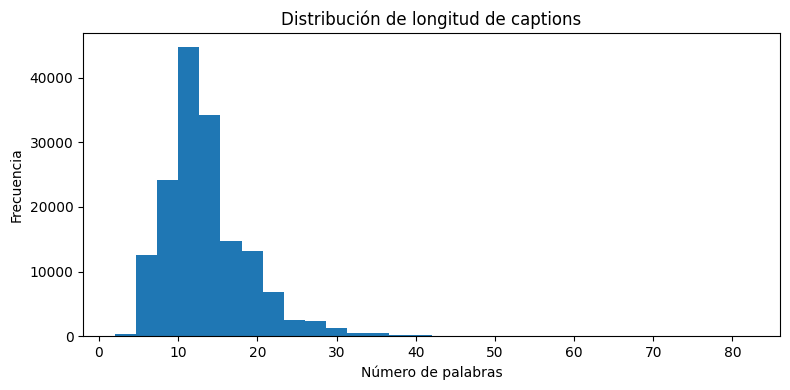

In [15]:
df = df[df['word_count'] > 0].copy()
print("Total filas tras eliminar vacías:", len(df))
import matplotlib.pyplot as plt


# Estadísticos descriptivos
print(df['word_count'].describe())

# Histograma
plt.figure(figsize=(8,4))
plt.hist(df['word_count'], bins=30)
plt.xlabel("Número de palabras")
plt.ylabel("Frecuencia")
plt.title("Distribución de longitud de captions")
plt.tight_layout()
plt.show()


Ya que no hay ni captions vacías y el número es 5 por imagen, vamos a contar las 20 palabras mas frecuentes:

In [16]:
from collections import Counter
import re

all_text = " ".join(df['caption']).lower()
tokens   = re.findall(r'\b\w+\b', all_text)
most_common = Counter(tokens).most_common(20)

print("Top 20 palabras más frecuentes:")
for word, freq in most_common:
    print(f"{word}: {freq}")


Top 20 palabras más frecuentes:
a: 271475
in: 83450
the: 62926
on: 45646
and: 44269
man: 42585
is: 41060
of: 38812
with: 36179
woman: 22196
two: 21656
are: 20176
to: 17618
people: 17331
at: 16254
an: 15875
wearing: 15704
shirt: 14336
white: 13281
young: 13209


Limpieza y normalización de texto:

In [17]:

#!python -m spacy download en_core_web_sm


Al limpiar con spaCy se eliminaban los números, por ejemplo "two mans cleaning the window" -> "man cleaning the window"

He vuelto a repetir la limpieza esta vez dejando los números por que creo que si es importante si por ejemplo quieres filtar por número de personas o algo. (tarda unos 6 m)  

In [18]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

nlp = spacy.load("en_core_web_sm", disable=["parser","ner"])

def preprocess_keep_nums(text):
    doc = nlp(text.lower())
    tokens = []
    for token in doc:
        if token.is_alpha and (not token.is_stop or token.like_num):
            tokens.append(token.lemma_)
    return " ".join(tokens)

df["clean_caption"] = df["caption"].apply(preprocess_keep_nums)


In [19]:
print(df[["caption", "clean_caption"]].head(10))


                                             caption  \
0  Two young guys with shaggy hair look at their ...   
1   Two young , White males are outside near many...   
2   Two men in green shirts are standing in a yard .   
3       A man in a blue shirt standing in a garden .   
4            Two friends enjoy time spent together .   
5  Several men in hard hats are operating a giant...   
6  Workers look down from up above on a piece of ...   
7   Two men working on a machine wearing hard hats .   
8              Four men on top of a tall structure .   
9                         Three men on a large rig .   

                                   clean_caption  
0  two young guy shaggy hair look hand hang yard  
1         two young white male outside near bush  
2                 two man green shirt stand yard  
3                    man blue shirt stand garden  
4                    two friend enjoy time spend  
5       man hard hat operate giant pulley system  
6                    worke

El siguiente paso entonces es vectorizar con tfid:

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    max_features=5_000,
    ngram_range=(1,2),
    dtype=float
)
X_captions = vectorizer.fit_transform(df["clean_caption"])
print("TF–IDF matrix shape:", X_captions.shape)


c:\Users\hered\anaconda3\envs\tf_env\lib\site-packages\sklearn\feature_extraction\text.py:2043: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. <class 'float'> 'dtype' will be converted to np.float64.
  warnings.warn(


TF–IDF matrix shape: (158749, 5000)


Ya se han convertito 158749 (filas) captions en vectores de 5000 dimensiones (columnas)

El siguiente paso es agrupar los vectores de captions por imagen. Hemos pasado de un vector por caption a una matriz grande pero queremos un vecgtor por imagen, agregando los 5 captions de cada imagen.

In [21]:
import numpy as np

# 1) Lista de nombres de imagen en el orden de las filas de X_captions
image_ids = df["imagen"].values

# 2) Construir un diccionario imagen → lista de índices de fila
idxs_per_image = {}
for idx, img in enumerate(image_ids):
    idxs_per_image.setdefault(img, []).append(idx)

# 3) Para cada imagen, promediar sus vectores TF–IDF
X_img = np.vstack([
    X_captions[idxs].mean(axis=0).A1   # .A1 convierte de sparse matrix a array 1D
    for idxs in idxs_per_image.values()
])

print("Matriz por imagen:", X_img.shape)


Matriz por imagen: (31750, 5000)


In [22]:
print("Número de imágenes distintas:", len(idxs_per_image))


Número de imágenes distintas: 31750


Proximo paso: extraer características visuales. x_img captura info textual pero necesitamos el otro vector que represente cada imagen por sus píxeles.

In [23]:
#pip install git+https://github.com/openai/CLIP.git


Esto tarda hora y 20 aprox

In [24]:
from transformers import CLIPProcessor, CLIPModel
import torch
from PIL import Image
import os
import numpy as np

# 0) Setup de dispositivo GPU/CPU
device = "cuda" if torch.cuda.is_available() else "cpu"

# 1) Carga modelo y processor
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# 2) Función para extraer el vector de una imagen
def extract_clip_feat(path):
    image = Image.open(path).convert("RGB")
    # Envío de los inputs al mismo device que el modelo:
    inputs = processor(images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        feats = model.get_image_features(**inputs)
    return feats.cpu().numpy().squeeze()  # vector de 512 dims

# 3) Aplica a todas las imágenes
visual_feats = []
for img_name in idxs_per_image:
    img_path = os.path.join(images_dir, img_name)
    visual_feats.append(extract_clip_feat(img_path))

V_img = np.vstack(visual_feats)  # shape (31750, 512)
print("Visual feature matrix:", V_img.shape)


c:\Users\hered\anaconda3\envs\tf_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Visual feature matrix: (31750, 512)


In [25]:
import numpy as np
np.save("V_img.npy", V_img)
np.save("X_img.npy", X_img)


Normalizamos:

In [26]:
from sklearn.preprocessing import StandardScaler

# Carga (si acabas de reiniciar kernel)
V = np.load("V_img.npy")
X = np.load("X_img.npy")

scaler_v = StandardScaler().fit(V)
scaler_x = StandardScaler().fit(X)

Vn = scaler_v.transform(V)
Xn = scaler_x.transform(X)


Reducimos dimensionalidad:

In [27]:
from sklearn.decomposition import PCA

pca_v = PCA(n_components=50).fit(Vn)
pca_x = PCA(n_components=50).fit(Xn)

Vp = pca_v.transform(Vn)
Xp = pca_x.transform(Xn)


Combinación de espacios con fusión temprana:

In [28]:
import numpy as np

Z = np.hstack([Vp, Xp])           # shape (n_imágenes, 100)
print("Embeddings fusionados:", Z.shape)


Embeddings fusionados: (31750, 100)


# Modelos


**BlipProcessor**
Es la clase encargada de preparar las imágenes (y texto, en tareas de VQA) para el modelo BLIP. Se ocupa de:

1. Redimensionar y normalizar la imagen al formato que espera el encoder visual.

2. Tokenizar, rellenar y enmascarar texto si hay input textual (no en nuestro caso de solo captioning).

3. Empaquetar todo en tensores PyTorch listos para entrar al modelo.

**BlipForConditionalGeneration**
Es el modelo de generación de captions de BLIP. Consta de:

1. Un encoder visual (basado en ViT) que convierte la imagen en representaciones latentes.

2. Un decoder tipo Transformer que, condicionándose en esos latentes, genera palabra a palabra una descripción.

3. Se entrena con un objetivo de generación de lenguaje sobre pares (imagen, caption) y también con objetivos contrastivos para alinear texto e imagen.

Estos dos componentes trabajan juntos para tomar la imagen, procesarla y producir uno o varios captions coherentes con lo que “ven” los pesos aprendidos de BLIP.

In [29]:
from transformers import BlipProcessor, BlipForConditionalGeneration

processor_blip = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model_blip     = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)


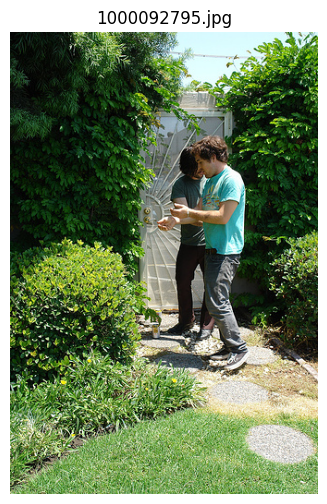

1000092795.jpg → a man standing in the grass


In [37]:
def describe_image(img_path):
    img = Image.open(img_path).convert("RGB")
    inputs = processor_blip(images=img, return_tensors="pt").to(device)
    model_blip.eval()
    with torch.no_grad():
        out = model_blip.generate(**inputs, max_length=40)
    caption = processor_blip.decode(out[0], skip_special_tokens=True)
    return caption

def show_and_describe(img_name):
    img_path = os.path.join(images_dir, img_name)
    
    img = Image.open(img_path).convert("RGB")
    plt.figure(figsize=(6,6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(img_name)
    plt.show()
    
    desc = describe_image(img_path)
    print(f"{img_name} → {desc}")

example = "1000092795.jpg"
show_and_describe(example)


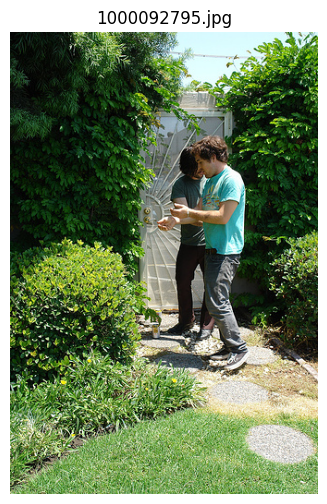

1000092795.jpg → a man standing in the grass


In [39]:
example = "1000092795.jpg"
show_and_describe(example)

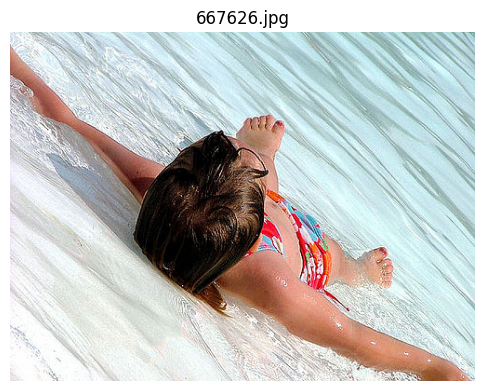

667626.jpg → a woman in a bikini on a surfboard


In [40]:
example = "667626.jpg"
show_and_describe(example)

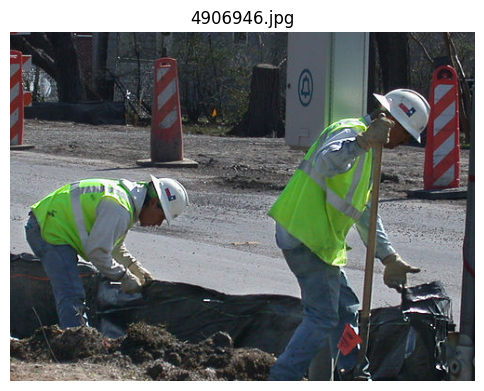

4906946.jpg → two men digging dirt in the street


In [41]:
example = "4906946.jpg"
show_and_describe(example)

### mismo modelo generando varias hipótesis

In [42]:
from PIL import Image
import matplotlib.pyplot as plt
import os

def show_and_describe_multibeam(img_name, num_beams=5, num_return_sequences=3, max_length=40):
    img_path = os.path.join(images_dir, img_name)
    
    # 1) Abrir y mostrar la imagen
    img = Image.open(img_path).convert("RGB")
    plt.figure(figsize=(6,6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(img_name)
    plt.show()
    
    # 2) Prepara inputs para BLIP
    inputs = processor_blip(images=img, return_tensors="pt").to(device)
    
    # 3) Genera múltiples captions
    out = model_blip.generate(
        **inputs,
        num_beams=num_beams,
        num_return_sequences=num_return_sequences,
        max_length=max_length,
        early_stopping=True
    )
    captions = [processor_blip.decode(o, skip_special_tokens=True) for o in out]
    
    # 4) Imprime las hipótesis
    print(f"{img_name} → Generadas {len(captions)} hipótesis:")
    for i, cap in enumerate(captions, 1):
        print(f"  {i}) {cap}")
    print()



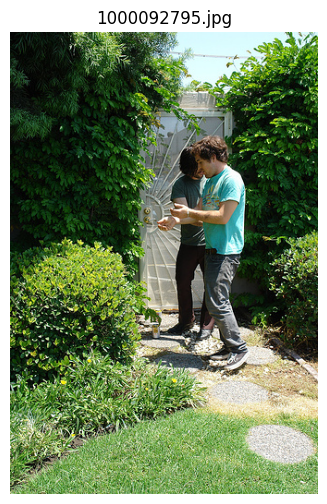

1000092795.jpg → Generadas 3 hipótesis:
  1) a man in a blue shirt
  2) a man standing in the grass
  3) a man standing in a yard



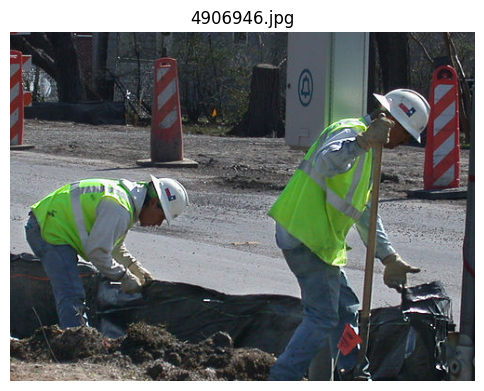

4906946.jpg → Generadas 3 hipótesis:
  1) a group of men working on a construction site
  2) a group of construction workers working on a road
  3) a group of construction workers working on a street



In [43]:
# Ejemplos de uso
for example in ["1000092795.jpg", "4906946.jpg"]:
    show_and_describe_multibeam(example)


## BLIP entrenado

Creamos las carpetas TRAIN TEST

In [46]:
import shutil
from sklearn.model_selection import train_test_split
import os

# Directorios originales y destino
images_dir = r"C:\Users\hered\Desktop\máster\AINE\ProyectoAINE\AINE\AINE\data\archive\Images"
base_dir = r"C:\Users\hered\Desktop\máster\AINE\ProyectoAINE\AINE\AINE\data"

train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Lista imágenes únicas
unique_images = df['imagen'].unique()

# División 80% train, 20% test
train_imgs, test_imgs = train_test_split(unique_images, test_size=0.2, random_state=42)

# Copiar imágenes a las carpetas correspondientes
def copy_images(img_list, dest_folder):
    for img_name in img_list:
        src = os.path.join(images_dir, img_name)
        dst = os.path.join(dest_folder, img_name)
        if not os.path.isfile(dst):
            shutil.copy(src, dst)

copy_images(train_imgs, train_dir)
copy_images(test_imgs, test_dir)

print(f"Imágenes en train: {len(os.listdir(train_dir))}")
print(f"Imágenes en test: {len(os.listdir(test_dir))}")

# Crear dataframes de captions para train/test
df_train = df[df['imagen'].isin(train_imgs)].reset_index(drop=True)
df_test = df[df['imagen'].isin(test_imgs)].reset_index(drop=True)


import torch
from torch.utils.data import Dataset
from PIL import Image

class CaptionDataset(Dataset):
    def __init__(self, df_captions, images_folder, processor, max_length=40):
        self.df = df_captions
        self.images_folder = images_folder
        self.processor = processor
        self.max_length = max_length
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.images_folder, row['imagen'])
        image = Image.open(img_path).convert("RGB")
        caption = row['caption']
        
        # Procesar imagen y texto
        inputs = self.processor(images=image, text=caption, 
                                return_tensors="pt", padding="max_length", truncation=True, max_length=self.max_length)
        
        # Squeeze batch dimension
        item = {k: v.squeeze(0) for k,v in inputs.items()}
        
        # Los labels son los input_ids del texto
        item["labels"] = item["input_ids"].clone()
        
        # Opcional: para ignorar tokens padding en la pérdida
        item["labels"][item["labels"] == self.processor.tokenizer.pad_token_id] = -100
        
        return item



from torch.utils.data import DataLoader

train_dataset = CaptionDataset(df_train, train_dir, processor_blip)
test_dataset = CaptionDataset(df_test, test_dir, processor_blip)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8)


from torch.optim import AdamW
from tqdm import tqdm

optimizer = AdamW(model_blip.parameters(), lr=5e-5)

epochs = 3

for epoch in range(epochs):
    model_blip.train()
    loop = tqdm(train_loader, leave=True)
    total_loss = 0
    for batch in loop:
        optimizer.zero_grad()
        batch = {k: v.to(device) for k,v in batch.items()}
        outputs = model_blip(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        loop.set_description(f"Epoch {epoch+1}")
        loop.set_postfix(loss=loss.item())
    avg_train_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1} - loss promedio train: {avg_train_loss:.4f}")
    
    # Validación
    model_blip.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            batch = {k: v.to(device) for k,v in batch.items()}
            outputs = model_blip(**batch)
            val_loss += outputs.loss.item()
    avg_val_loss = val_loss / len(test_loader)
    print(f"Epoch {epoch+1} - loss promedio val: {avg_val_loss:.4f}")


Imágenes en train: 25400
Imágenes en test: 6350


Epoch 1:   1%|          | 83/15875 [26:57<85:29:29, 19.49s/it, loss=3.03]


KeyboardInterrupt: 

In [ ]:
# Guardar modelo
model_blip.save_pretrained("blip_finetuned")
processor_blip.save_pretrained("blip_finetuned")



In [ ]:

# --- Ejemplo de visualización de predicción ---

import matplotlib.pyplot as plt
from PIL import Image

def generate_caption(image_path, num_beams=5, max_length=40):
    img = Image.open(image_path).convert("RGB")
    inputs = processor_blip(images=img, return_tensors="pt").to(device)
    model_blip.eval()
    with torch.no_grad():
        outputs = model_blip.generate(
            **inputs,
            num_beams=num_beams,
            max_length=max_length,
            early_stopping=True
        )
    caption = processor_blip.decode(outputs[0], skip_special_tokens=True)
    return img, caption

# Escoge una imagen del test para visualizar
example_img_name = test_imgs[0]
example_img_path = os.path.join(test_dir, example_img_name)

img, generated_caption = generate_caption(example_img_path)
plt.imshow(img)
plt.axis('off')
plt.title(f"Generado: {generated_caption}")
plt.show()

print(f"Caption generado para {example_img_name}:")
print(generated_caption)